# Úkol č. 3 - Segmentace zákazníků e-shopu
**Deadline úkolu je uveden na [course pages](https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html).**

Jednou z důležitých aplikací shlukování je **segmentace zákazníků** (angl. **customer segmentation**). 

Předpokládejme, že máme následující obchodní údaje o prodejích (resp. nákupech z pohledu zákazníků):
TransactionID - ID nákupu,
CustomerID - ID zákazníka, 
Date - datum nákupu, 
Total - celková cena nákupu.

Chceme najít segmenty zákazníků, kteří se chovají podobně. K tomu je dobré informace z jednotlivých nákupů pro individuální zákazníky agregovat. Tj. získat pro každého zákazníka jeden řádek.

Populárním přístupem je **RFM**, což znamená:

- **R**ecency: Počet dnů od posledního nákupu (poslední datum v datasetu pro daného zákazníka).
- **F**requency: Počet nákupů. Občas se vynechávají zákazníci s jediným nákupem. Pro jednoduchost je zde ale necháme.
- **M**onetary: Celková suma, kterou daný zákazník utratil.

## Zdroj dat
Budeme pracovat s daty z jednoho (skoro) vymyšleného eshopu, která jsou v přiloženém souboru `eshop.csv`.

## Pokyny k vypracování

Ve všech bodech zadání uvažujte aktuální datum jako datum poslední transakce (19. 12. 2015), nikoliv dnešek. Tváříme se, že jde o aktuální data.

**Základní body zadání**, za jejichž (poctivé) vypracování získáte **8 bodů**:
- Vytvořte `rfm` data frame, kde každý řádek odpovídá jednomu zákazníkovi a sloupce (příznaky) jsou uvedené výše.
- Pomocí algoritmu `K-means` proveďte shlukování. Nějakým způsobem také odhadněte nejlepší počet shluků (podrobně vysvětlete).
- Zabývejte se vlivem přeškálování dat (standardizace příznaků). Tj. určete, zda je přeškálování vhodné, a proveďte ho.
- Interpretujte jednotlivé shluky. Použijte získané shluky k odlišení "superstar" zákazníků (vysoká monetary, vysoká frequency a nízká recency) od nezajímavých  zákazníků (vysoká recency, nízká frequency, nízká monetary).

**Další body zadání** za případné další body  (můžete si vybrat, maximum bodů za úkol je každopádně 12 bodů):
- (až +4 body) Proveďte analýzu vytvořených shluků pomocí metody silhouette (https://en.wikipedia.org/wiki/Silhouette_(clustering)).
- (až +4 body) Zkuste provést to samé s modifikovanou verzí **RFM**, kde Recency = "maximum počtu měsíců od posledního nákupu a čísla 1", Frequency = "maximum počtu nákupů daného zákazníka v posledních 12 měsících a čísla 1", Monetary = "Nejvyšší hodnota nákupu daného zákazníka". Porovnejte s původním přístupem.

## Poznámky k odevzdání

  * Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-VZD/homeworks/index.html.
  * Odevzdejte Jupyter Notebook.
  * Opravující Vám může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale důležitá a bude-li odbytá, budete za to penalizováni.

# Import

In [1]:
import pandas as pd
from scipy.cluster.hierarchy import dendrogram, linkage
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from collections import Counter, defaultdict
import numpy as np
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import MinMaxScaler

D:\Program Files\Anaconda\lib\site-packages\sklearn\utils\deprecation.py:143: FutureWarning: The sklearn.metrics.classification module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.metrics. Anything that cannot be imported from sklearn.metrics is now part of the private API.
  warnings.warn(message, FutureWarning)


# Příprava dat

In [2]:
data = pd.read_csv('eshop.csv')
data['Date'] = pd.to_datetime(data['Date']) # převedení sloupce 'Date' do požadovaného formátu
display(data.head())

Customer ID       Date  Subtotal         Country
0           34 2007-06-21      86.0  Czech Republic
1           38 2007-06-27      38.4  Czech Republic
2           47 2007-07-02      53.5        Slovakia
3           61 2007-07-14       7.0  Czech Republic
4           78 2007-07-21      55.5  Czech Republic

# Tvorba RFM datasetu
Data jsem setřídil podle 'Customer ID' pomocí groupby. Pro spočítání 'Recency' jsem od "dnešního" data odečetl datum posledního nákupu.

In [3]:
datarfm = pd.DataFrame(columns = ['Recency', 'Frequency', 'Monetary'])
group = data.groupby('Customer ID')
today = pd.to_datetime('19/12/2015')
datarfm['Monetary'] = group['Subtotal'].sum()
datarfm['Frequency'] = group['Subtotal'].count()
datarfm['Recency'] = (today - group['Date'].max()).dt.days
display(datarfm.head())

Recency  Frequency  Monetary
Customer ID                              
7                311          3     15.54
9               3050          1     13.20
30              3025          1     36.20
34              3103          1     86.00
38              3097          1     38.40

# Standartizace
Zobrazil jsem si informace o datech, abych zjistil, jaké mají jednotlivé příznaky rozložení.

In [4]:
display(datarfm.describe())

Recency     Frequency      Monetary
count  12829.000000  12829.000000  12829.000000
mean    1102.619690      1.746668    155.806657
std      726.546225      2.010044    407.744435
min        0.000000      1.000000      1.180000
25%      456.000000      1.000000     32.040000
50%     1062.000000      1.000000     64.810000
75%     1681.000000      2.000000    143.510000
max     3103.000000     45.000000  21392.380000

Příznaky 'Rcency' a 'Monetary' se pohybují ve stovkách až v tisících, zatímco příznak 'Frequency' se pohybuje v jednotkách až v desítkách. Příznak 'Frequency' by měl na shlukování velmi malý vliv. Provedl jsem tedy standartizaci.

In [5]:
scaler = MinMaxScaler()
dataScaled = scaler.fit_transform(datarfm)

# Shlukování

## Výběr vhodného počtu shluků
Použil jsem balíček KElbowVisualizer.

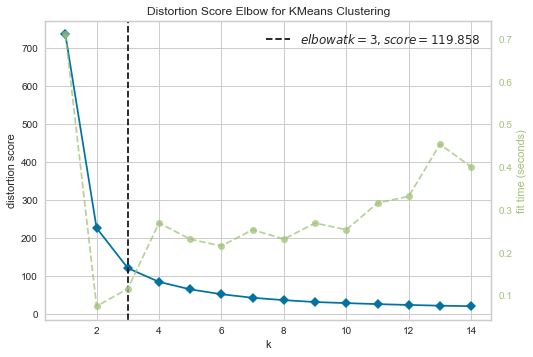

In [6]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,15))

visualizer.fit(dataScaled)
visualizer.show()

## Rozdělení do shluků
Se zvoleným k = 3 jsem provedl shlukování pomocí algoritmu KMeans.

In [7]:
k = 3
kmeans = KMeans(n_clusters = k, random_state = 1).fit(dataScaled)

display(kmeans.cluster_centers_)
display(Counter(kmeans.labels_))

array([[0.10739311, 0.028885  , 0.01062833],
       [0.66033205, 0.00651589, 0.00394053],
       [0.3764867 , 0.01281939, 0.00627187]])

Counter({0: 4654, 1: 3484, 2: 4691})

Shluk 0 představuje "superstar" zákazníky s vysokou 'Monetary' a 'Frequency' a nízkou 'Recency', shluk 2 představuje průměrné zákazníky a shluk 1 představuje nezajímavé zákazníky s nízkou 'Monetary' a 'Frequency' a vysokou 'Recency'.

## Vyfiltrování "superstar" zákazníků.
Do RFM datasetu jsem přidal sloupec 'Cluster' a podle něj vyfiltroval zákazníky ze shluku 0.

In [8]:
datarfm.insert(3, "Cluster", kmeans.labels_, True)
superstars = datarfm[datarfm['Cluster'] == 0].drop(columns=['Cluster'])
display(superstars.head())

Recency  Frequency  Monetary
Customer ID                              
7                311          3     15.54
77               409          1     23.39
115              411          7    904.48
167               72          2     69.16
216               32         19   2614.37

# Upravené RFM
Pro výpočet příznaku 'Frequency' jsem vyfiltroval data z posledního roku a setřídil je zvlášť. Kde bylo potřeba, nahradil jsem hodnoty menší než 1 hodnotou 1.

In [9]:
datarfm = pd.DataFrame(columns = ['Recency', 'Frequency', 'Monetary'])
group = data.groupby('Customer ID')
today = pd.to_datetime('19/12/2015')
relevantData = data[(today - data['Date']).dt.days < 365] # Data z posledního roku
relevantGroup = relevantData.groupby('Customer ID') # Setříděná data z posledního roku
datarfm['Monetary'] = group['Subtotal'].max()
datarfm['Frequency'] = relevantGroup['Subtotal'].count()
datarfm['Recency'] = (today - group['Date'].max()).dt.days / 30
datarfm = datarfm.fillna(1) # Nahrazení hodnot u příznaku 'Frequency' s žádným nákupem za poslední rok hodnotou 1
datarfm['Recency'] = datarfm['Recency'].apply(lambda x: 1 if x < 1 else x) # Nahrazení hodnot u příznaku 'Recency' menších než 1 hodnotou 1
display(datarfm.head())

Recency  Frequency  Monetary
Customer ID                                 
7             10.366667        1.0     13.28
9            101.666667        1.0     13.20
30           100.833333        1.0     36.20
34           103.433333        1.0     86.00
38           103.233333        1.0     38.40

In [10]:
display(datarfm.describe())

Recency     Frequency      Monetary
count  12829.000000  12829.000000  12829.000000
mean      36.765261      1.090420     95.009815
std       24.201402      0.532328    245.934027
min        1.000000      1.000000      1.180000
25%       15.200000      1.000000     30.510000
50%       35.400000      1.000000     56.670000
75%       56.033333      1.000000    109.040000
max      103.433333     18.000000  21001.050000

Příznak 'Monetary' se opět pohybuje až v tisících na rozdíl od ostatních. Opět jsem tedy provedl standartizaci.

In [11]:
scaler = MinMaxScaler()
dataScaled = scaler.fit_transform(datarfm)

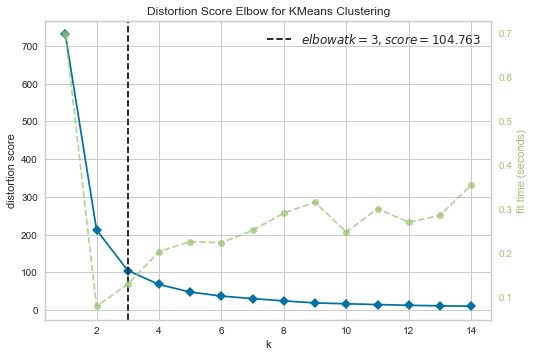

In [12]:
model = KMeans()
visualizer = KElbowVisualizer(model, k=(1,15))

visualizer.fit(dataScaled)
visualizer.show()

In [13]:
k = 3
kmeans = KMeans(n_clusters = k, random_state = 1).fit(dataScaled)

display(kmeans.cluster_centers_)
display(Counter(kmeans.labels_))

array([[ 9.74120759e-02,  1.47471999e-02,  5.38347194e-03],
       [ 6.56026976e-01, -9.19403442e-17,  3.22865405e-03],
       [ 3.68155869e-01, -6.50521303e-17,  4.49130907e-03]])

Counter({0: 4614, 1: 3499, 2: 4716})

Shluky představují stejné skupiny jako v původním případě. Upřímně nechápu, jak mohla ve středech vyjít záporná čísla, když se všechny hodnoty pohybují mezi 0 a 1.

In [14]:
datarfm.insert(3, "Cluster", kmeans.labels_, True)
superstars = datarfm[datarfm['Cluster'] == 0].drop(columns=['Cluster'])
display(superstars.head())

Recency  Frequency  Monetary
Customer ID                                
7            10.366667        1.0     13.28
77           13.633333        1.0     23.39
115          13.700000        1.0    211.88
167           2.400000        2.0     65.43
216           1.066667        4.0    254.85

Výsledné shlukování vyšlo takřka stejně, jako v původním případě.